<div>
    <center>
    <h1> Double pendulum </h1>
    <br>
    by <a href="http://github.com/ComputoCienciasUniandes"> ComputoCienciasUniandes </a>
    <br>
    <a href="http://github.com/jsbarbosa"> Juan Barbosa </a>
    </center>
</div>
<hr style="height:5px">

# Librerías

In [1]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

%matplotlib

Using matplotlib backend: Qt5Agg


# Sistema

Para el péndulo doble las ecuaciones de movimiento se obtienen a partir del lagrangiano del sistema.
$$L(q_1, ... q_n, \dot{q_1}, ..., \dot{q_n}) = T - V$$

<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg" width=200px>

Con el objetivo de reducir el número de coordenadas para describir el sistema se usan las coordenadas generalizadas $\theta_1$ y $\theta_2$.

$$
\matrix
{
    x_1 = L_1\sin\theta_1 & \qquad & y_1 = -L_1\cos\theta_1\\
    x_2 = x_1 + L_2\sin\theta_2 & \qquad & y_2 = y_1 - L_2\cos\theta_2\\
}
$$

In [2]:
import sympy as spy
from scipy.constants import g as G
from IPython.display import display
spy.init_printing()

In [3]:
L1, L2, t, m1, m2, g = spy.symbols('L_1 L_2 t m_1 m_2 g', real = True, positive = True)

theta1 = spy.Function(r'\theta_1')(t)
theta2 = spy.Function(r'\theta_2')(t)

dtheta1 = spy.Function(r'\dot{\theta_1}')(t)
ddtheta1 = spy.Function(r'\ddot{\theta_1}')(t)
dtheta2 = spy.Function(r'\dot{\theta_2}')(t)
ddtheta2 = spy.Function(r'\ddot{\theta_2}')(t)

symbols_dict = {theta1.diff(t) : dtheta1, theta1.diff(t).diff(t) : ddtheta1, dtheta1.diff(t) : ddtheta1,
               theta2.diff(t) : dtheta2, theta2.diff(t).diff(t) : ddtheta2, dtheta2.diff(t) : ddtheta2}

x1 = L1 * spy.sin(theta1)
y1 = -L1 * spy.cos(theta1)
x2 = x1 + L2 * spy.sin(theta2)
y2 = y1 - L2 * spy.cos(theta2)

La energía cinética se obtiene usando:
$$T = T_1 + T_2 = \dfrac{1}{2}m_1v_1^2 + \dfrac{1}{2}m_2v_2^2$$
las velocidades 

$$v_i = \sqrt{\dot{x_i}^2 + \dot{y_i}^2}$$

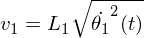

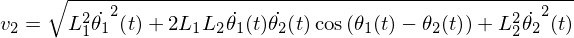

In [4]:
v1 = spy.sqrt(x1.diff(t)**2 + y1.diff(t)**2).subs(symbols_dict).simplify()
v2 = spy.sqrt(x2.diff(t)**2 + y2.diff(t)**2).subs(symbols_dict).simplify()


display(spy.Eq(spy.symbols('v1'), v1))
display(spy.Eq(spy.symbols('v2'), v2))

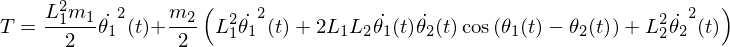

In [5]:
T = (m1*v1**2/2 + m2*v2**2/2).simplify()
spy.Eq(spy.symbols('T'), T)

La energía potencial corresponde entonces con: $V = V_1 + V_2 = m_1gy_1 + m_2gy_2$

In [6]:
V = (m1*g*y1 + m2*g*y2).simplify()
spy.Eq(spy.symbols('V'), V)

El lagrangiano $L$ es entonces:

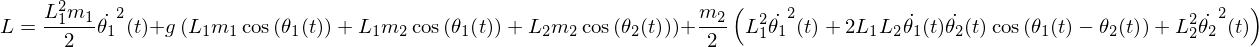

In [7]:
L = (T - V).simplify()
spy.Eq(spy.symbols('L'), L)

La ecuación de Euler-Lagrange es:
$$
    \dfrac{d}{dt}\dfrac{dL}{d\dot{q_i}} - \dfrac{dL}{dq_i} = 0
$$

donde $p_i = \dfrac{dL}{d\dot{q_i}}$, corresponde con el momento generalizado

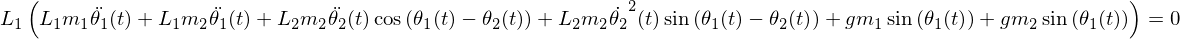

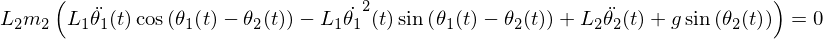

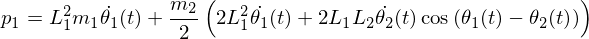

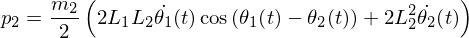

In [8]:
p1 = L.diff(dtheta1)
p2 = L.diff(dtheta2)

Ltheta1 = (p1.diff(t) - L.diff(theta1)).subs(symbols_dict).simplify()
Ltheta2 = (p2.diff(t) - L.diff(theta2)).subs(symbols_dict).simplify()

eq1 = spy.Eq(Ltheta1, 0)
eq2 = spy.Eq(Ltheta2, 0)

display(eq1)
display(eq2)

display(spy.Eq(spy.symbols('p_1'), p1))
display(spy.Eq(spy.symbols('p_2'), p2))

Despejando las expresiones anteriores para $\ddot{\theta_1}$ y $\ddot{\theta_2}$:

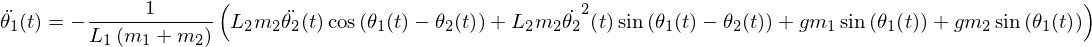

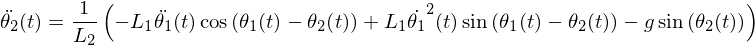

In [9]:
ddtheta1_ = spy.solve(eq1, ddtheta1)[0]
ddtheta2_ = spy.solve(eq2, ddtheta2)[0]

display(spy.Eq(ddtheta1, ddtheta1_))
display(spy.Eq(ddtheta2, ddtheta2_))

Las ecuaciones anteriores están acopladas: $\ddot{\theta_1} = \ddot{\theta_1}(\ddot{\theta_2})$, $\ddot{\theta_2} = \ddot{\theta_2}(\ddot{\theta_1})$

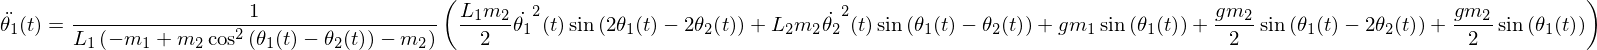

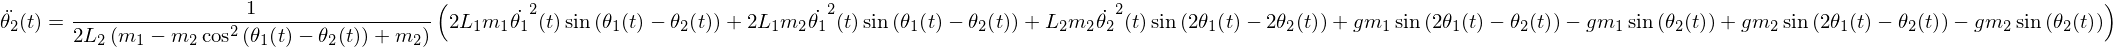

In [10]:
ddtheta1__ = ddtheta1_.subs({ddtheta2: ddtheta2_})
ddtheta2__ = ddtheta2_.subs({ddtheta1: ddtheta1_})

ddtheta1__ = spy.solve(spy.Eq(ddtheta1__, ddtheta1), ddtheta1)[0].simplify()
ddtheta2__ = spy.solve(spy.Eq(ddtheta2__, ddtheta2), ddtheta2)[0].simplify()

display(spy.Eq(ddtheta1, ddtheta1__))
display(spy.Eq(ddtheta2, ddtheta2__))

# Soluciones

In [11]:
def derivs(state, t):
    #dydx [dtheta1, ddtheta1, dtheta2, ddtheta2] 
    #state [theta1, dtheta1, theta2, dtheta2]

    dydx = np.zeros_like(state)
    
    theta1, dtheta1, theta2, dtheta2 = state
    dydx[0] = dtheta1

    theta_diff = theta1 - theta2
    den1 = L1*(m2*cos(theta_diff)**2 - m1 - m2)
    
    dydx[1] = 0.5*L1*m2*dtheta1**2*sin(2*theta_diff) + \
               L2*m2*dtheta2**2*sin(theta_diff) + \
               G*m1*sin(theta1) + 0.5*G*m2*sin(theta1 - 2*theta2) + 0.5*G*m2*sin(theta1)
            
    dydx[1] *= 1./den1 

    dydx[2] = dtheta2

    den2 = 2*L2*(m1 + m2 - m2*cos(theta_diff)**2)
    dydx[3] = 2*L1*m1*dtheta1**2*sin(theta_diff) + 2*L1*m2*dtheta1**2*sin(theta_diff) \
            + L2*m2*dtheta2**2*sin(2*theta_diff) + G*m1*sin(2*theta1 - theta2) - G*m1*sin(theta2)\
            + G*m2*sin(2*theta1 - theta2) - G*m2*sin(theta2)
            
    dydx[3] *= 1./den2

    return dydx

# Condiciones iniciales

In [12]:
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
m1 = 1.0  # mass of pendulum 1 in kg
m2 = 1.0  # mass of pendulum 2 in kg

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = 120.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# Gráficas

In [14]:
# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 20, dt)

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

theta1, dtheta1, theta2, dtheta2 = y.T

x1 = L1*sin(theta1)
y1 = -L1*cos(theta1)

x2 = L2*sin(theta2) + x1
y2 = -L2*cos(theta2) + y1

L = abs(L1) + abs(L2)

fig, ax1 = plt.subplots()
ax1.grid()

line, = ax1.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax1.text(0.05, 0.9, '', transform=ax1.transAxes)

trajectory, = ax1.plot([], [], alpha = 0.1, c = 'b')

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    trajectory.set_data(x2[:i], y2[:i])
    time_text.set_text(time_template % (i*dt))
    return line, trajectory, time_text

ax1.set_xlim(-L, L)
ax1.set_ylim(-L, L)
ax1.set_xlabel("$x$ (m)")
ax1.set_ylabel("$y$ (m)")
ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=25, blit=True, init_func=init)

# ani.save("DoublePendulum.gif", writer="imagemagick")
plt.show()